# Retrieval-Augmented Generation (RAG) with QuotientAI and Qdrant

This notebook introduces the concept of Retrieval-Augmented Generation (RAG) and its significance in enhancing language models by integrating external knowledge retrieval, and it demonstrates how to implement it using the `quotientai` library in conjunction with [Qdrant](https://qdrant.tech/) for vector database management.

To see more examples of `quotientai` for evaluating your AI products, see our notebook library at: https://bit.ly/quotient-notebook.

**Note**: To run this notebook (or use `quotientai`), you will first need to request access on [Quotient's website](https://www.quotientai.co/).

## Table of Contents
1. Introduction to **Retrieval-Augmented Generation (RAG)**
2. Setting up the Environment
3. Setting up and connecting to [Qdrant](https://qdrant.tech/)
4. Preparing Data for Retrieval
5. Checkout Evaluation dataset
6. Building and Evaluating your RAG pipeline
7. Setting up with [Quotient](https://www.quotientai.co/)
8. Optimizing RAG through **Experimentation**
9. Conclusion


### **1. Introduction to Retrieval-Augmented Generation (RAG)**

Retrieval-Augmented Generation (RAG) is a methodology that combines the generative capabilities of language models with the retrieval of external knowledge to enhance the model's outputs.

It enables models to access a vast repository of information, thus improving the quality and relevance of generated content.

### **2. Set up & import the relevant packages**

To get started, we need to import the required libraries.

In [224]:
import os
import pandas as pd
import qdrant_client
import tqdm.notebook as tqdm
from dotenv import load_dotenv
from datasets import load_dataset

In [225]:
load_dotenv()

True

### **3. Connecting to Qdrant Vector Database**

Qdrant is a vector database designed for efficient storage and retrieval of high-dimensional vectors.

It is ideal for use cases like RAG, where retrieving relevant information quickly is crucial.

We can use Qdrant in 3 different listed ways, we are using [Qdrant Cloud](https://cloud.qdrant.io/login) in this workshop today.


In [226]:
##Uncomment to initialise qdrant client in memory
# client = qdrant_client.QdrantClient(
#    location=":memory:",
# )

##Uncomment below to connect to Qdrant Cloud
client = qdrant_client.QdrantClient(
    os.environ.get("QDRANT_URL"),
    api_key=os.environ.get("QDRANT_API_KEY"),
)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

#### **3.1 General Collection level operations**

In [227]:
## Collection name is dynamically generated based on o
#COLLECTION_NAME = "qdrant-docs-quotient"

## Get information about existing collections
client.get_collections()

## Get information about specific collection
#collection_info = client.get_collection(COLLECTION_NAME)
#print(collection_info)

## Deleting collection , if need be
#client.delete_collection(COLLECTION_NAME)

CollectionsResponse(collections=[CollectionDescription(name='qdrant_docs_arize_hybrid'), CollectionDescription(name='experiment_512_64_all-MiniLM-L6-v2'), CollectionDescription(name='qdrant-docs-ragas-haystack-mxbai'), CollectionDescription(name='experiment_1024_128_bge-small-en'), CollectionDescription(name='qdrant_docs_arize_dense'), CollectionDescription(name='qdrant-docs-ragas'), CollectionDescription(name='email'), CollectionDescription(name='qdrant-docs-ragas-haystack-mxbai-livestream'), CollectionDescription(name='hybrid_experiment_512_64_bge-small-en'), CollectionDescription(name='experiment_512_64_bge-small-en')])

#### **3.2 Getting familiar with [Fastembed](https://qdrant.github.io/fastembed/)** 

To help us provide seamless embedding creations throughout the workshop.

In [228]:
## Declaring the intended Embedding Model with Fastembed
from fastembed.embedding import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

,model,dim,description,size_in_GB,sources,model_file,additional_files
0,BAAI/bge-base-en,768,Base English model,0.420,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
1,BAAI/bge-base-en-v1.5,768,"Base English model, v1.5",0.210,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
2,BAAI/bge-large-en-v1.5,1024,"Large English model, v1.5",1.200,{'hf': 'qdrant/bge-large-en-v1.5-onnx'},model.onnx,NaN
3,BAAI/bge-small-en,384,Fast English model,0.130,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
4,BAAI/bge-small-en-v1.5,384,Fast and Default English model,0.067,{'hf': 'qdrant/bge-small-en-v1.5-onnx-q'},model_optimized.onnx,NaN
5,BAAI/bge-small-zh-v1.5,512,Fast and recommended Chinese model,0.090,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
6,sentence-transformers/all-MiniLM-L6-v2,384,"Sentence Transformer model, MiniLM-L6-v2",0.090,{'url': 'https://storage.googleapis.com/qdrant...,model.onnx,NaN
7,sentence-transformers/paraphrase-multilingual-...,384,"Sentence Transformer model, paraphrase-multili...",0.220,{'hf': 'qdrant/paraphrase-multilingual-MiniLM-...,model_optimized.onnx,NaN
8,nomic-ai/nomic-embed-text-v1,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1'},onnx/model.onnx,NaN
9,nomic-ai/nomic-embed-text-v1.5,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1.5'},onnx/model.onnx,NaN


In [229]:
## General Fastembed specific operations

##Initilising embedding model
## Using Default Model - BAAI/bge-small-en-v1.5
#embedding_model = TextEmbedding()

## For custom model supported by Fastembed
#embedding_model = TextEmbedding(model_name="BAAI/bge-small-en", max_length=512)
#embedding_model = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2", max_length=384)

## Verify the chosen Embedding model
#embedding_model.model_name

### **4. Preparing Dataset for Retrieval**
Before implementing RAG, we need to prepare and index our data in the Qdrant vector database.

This involves converting textual data into vectors using a suitable encoder (e.g., sentence transformers), and storing these vectors in Qdrant for retrieval later.

In this example we'll use [Qdrant's documentation](https://qdrant.tech/) so that we can evaluate the ability of a language model to answer questions about Qdrant.

In [230]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

## Load the dataset with qdrant documentation
dataset = load_dataset("atitaarora/qdrant_doc", split="train")

## Dataset to langchain document
langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in dataset
]

len(langchain_docs)

240

In [231]:
## Here's an example of what a document in our dataset looks like
print(dataset[100]['text'])

---

title: What is Qdrant?

weight: 9

aliases:

  - overview

---



# Introduction



![qdrant](https://qdrant.tech/images/logo_with_text.png)



Vector databases are a relatively new way for interacting with abstract data representations 

derived from opaque machine learning models such as deep learning architectures. These 

representations are often called vectors or embeddings and they are a compressed version of 

the data used to train a machine learning model to accomplish a task like sentiment analysis, 

speech recognition, object detection, and many others.



These new databases shine in many applications like [semantic search](https://en.wikipedia.org/wiki/Semantic_search) 

and [recommendation systems](https://en.wikipedia.org/wiki/Recommender_system), and here, we'll 

learn about one of the most popular and fastest growing vector databases in the market, [Qdrant](https://qdrant.tech).



## What is Qdrant?



[Qdrant](http://qdrant.tech) "is a vector similarity searc

### **5. Let's look at our evaluation dataset**

To measure the quality of our RAG setup, we will need a representative evaluation dataset. This dataset should contain realistic questions and the expected answers. 

If possible, you may also want to include the **ground truth and contexts** that you expected your RAG pipeline to retrieve.

In [232]:
import pandas as pd
from datasets import load_dataset

# Get our evaluation dataset
qdrant_qa = load_dataset("atitaarora/qdrant_doc_qna" | split="train")

eval_df = qdrant_qa.to_pandas().rename(columns={'question':'input_text'})[['input_text', 'answer']]

# Here are some examples of questions and ground truth answers from our evaluation dataset
with pd.option_context('display.max_colwidth', 0):
    display(eval_df.head(10))

,input_text,answer
0,What is vaccum optimizer ?,"The Vacuum Optimizer is a feature in the Qdrant database designed to manage and improve system performance by removing obsolete data. In Qdrant, when records are deleted, they are not immediately removed from the database. Instead, they are marked as deleted and subsequently ignored in future queries. This approach helps minimize disk access but results in accumulated deleted records that can occupy valuable memory and degrade performance over time.\nThe Vacuum Optimizer addresses this issue by systematically clearing out these marked-as-deleted records once they reach a certain threshold. This threshold is configurable and includes conditions such as the minimum fraction of deleted vectors in a segment and the minimum number of vectors present in a segment."
1,Tell me about ‘always_ram’ parameter?,"In the context of vector quantization in Qdrant, the 'always_ram' parameter determines whether quantized vectors should be kept always cached in RAM or not. By default, quantized vectors are loaded in the same manner as the original vectors. Setting 'always_ram' to true ensures that the quantized vectors are consistently cached in RAM, providing faster access times."
2,What is difference between scalar and product quantization?,"While both methods aim to reduce the memory footprint and potentially speed up operations, scalar quantization offers faster processing with SIMD-friendly operations and minimal accuracy loss, making it suitable for scenarios where speed is critical. Product quantization achieves higher compression rates and is better suited for handling very high-dimensional vectors where memory space is more of a concern than computation speed."
3,What is ‘best_score’ strategy?,"The `best_score` strategy is based on the idea of finding similar vectors by identifying those that are closer to a positive example while avoiding those that are closer to a negative one. This strategy measures each candidate against every example and selects the best positive and best negative scores. The final score is determined using a specific formula: if the best positive score is greater than the best negative score, the final score is set as the best positive score. Otherwise, the final score is calculated as the negative of the square of the best negative score. It is important to note that the performance of the `best_score` strategy is linearly impacted by the number of examples provided."
4,How does oversampling helps?,"Defines how many extra vectors should be pre-selected using quantized index, and then re-scored using original vectors. For example, if oversampling is 2.4 and limit is 100, then 240 vectors will be pre-selected using quantized index, and then top-100 will be returned after re-scoring. Oversampling is useful if you want to tune the tradeoff between search speed and search quality in the query time."
5,What is the purpose of ‘CreatePayloadIndexAsync’?,CreatePayloadIndexAsync is a method in the Qdrant library that enables the creation of a payload index in Qdrant. A payload index is a data structure designed to store supplemental information about the data stored in Qdrant. This method requires a Qdrant instance and a payload index name as input parameters.
6,What is the purpose of ef_construct in HNSW ?,"In HNSW algorithm the ef_construct parameter is the number of neighbours to consider during the index building. The larger the value, the higher the precision, but the longer the indexing time. The default values of this parameters 100"
7,How do you use ‘ordering’ parameter?,"Write ordering can be specified for any write request to serialize it through a single “leader” node, which ensures that all write operations (issued with the same ordering) are performed and observed sequentially. It is of 3 types weak , medium and strong and is used in python with additional param ordering=models.WriteOrdering.STRONG to upsert request."
8,What is significance of ‘on_disk_payload’ s

### **6. Building and Evaluating the RAG pipeline**

First, we define the data preprocessing properties for the RAG pipeline and populate the Qdrant vector database given the specified parameters. 
The parameters that we will be focusing on include:
- **chunk size**
- **chunk overlap**
- **embedding model**
- **number of documents retrieved (retrieval window)**

After ingesting data into the vector database, we retrieve documents relevant to each question and enhance our evaluation dataset by incorporating these documents into the `context` column.

In [233]:
def add_documents(client, collection_name, chunk_size, chunk_overlap, embedding_model_name):
    """
    This function adds documents to the desired Qdrant collection given the specified RAG parameters.
    """

    ## Processing each document with desired TEXT_SPLITTER_ALGO, CHUNK_SIZE, CHUNK_OVERLAP
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in langchain_docs:
        docs_processed += text_splitter.split_documents([doc])

    ## Processing documents to be encoded by Fastembed
    docs_contents = []
    docs_metadatas = []

    for doc in docs_processed:
        if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
            docs_contents.append(doc.page_content)
            docs_metadatas.append(doc.metadata)
        else:
            # Handle the case where attributes are missing
            print("Warning: Some documents do not have 'page_content' or 'metadata' attributes.")

    print("processed: ", len(docs_processed))
    print("content: ", len(docs_contents))
    print("metadata: ", len(docs_metadatas))

    ## Adding documents to Qdrant using desired embedding model
    client.set_model(embedding_model_name=embedding_model_name)
    client.add(collection_name=collection_name, metadata=docs_metadatas, documents=docs_contents)


def get_documents(collection_name, query, num_documents=3):
    """
    This function retrieves the desired number of documents from the Qdrant collection given a query.
    It returns a list of the retrieved documents.
    """
    search_results = client.query(
        collection_name=collection_name,
        query_text=query,
        limit=num_documents,
    )
    results = [r.metadata["document"] for r in search_results]
    return results

### **Reranking**

The concept of reranking, a crucial technique used to `refine and reorder results` generated by a primary retrieval model. 
By leveraging additional features or models, reranking enhances the relevance and accuracy of the final output, ensuring more precise results.

#### **a. Using Cohere**

In [347]:
import cohere
import time

COHERE_KEY=os.environ.get("COHERE_KEY")
co = cohere.Client(COHERE_KEY)

def get_reranked_documents_with_cohere(collection_name, query, num_documents=5):
    """
    This function retrieves the desired number of documents from the Qdrant collection given a query.
    It returns a list of the reranked retrieved documents.
    """
    
    search_results = client.query(
        collection_name=collection_name,
        query_text=query,
        limit=num_documents+4,
    )
    results = [r.metadata["document"] for r in search_results]
    
    response = co.rerank(
    model="rerank-english-v3.0",
    query=query,
    documents=results,
    top_n=num_documents,
    return_documents=True
    )

    time.sleep(6.1)
    
    return [doc.document.text for doc in response.results]

#### **b. Using Mixedbread AI**

In [313]:
from mixedbread_ai.client import MixedbreadAI

MXBAI_KEY=os.environ.get("MXBAI_API_KEY")
mxbai = MixedbreadAI(api_key=MXBAI_KEY)

def get_reranked_documents_with_mixedbread(collection_name, query, num_documents=5):
    """
    This function retrieves the desired number of documents from the Qdrant collection given a query.
    It returns a list of the reranked retrieved documents.
    """
    
    search_results = client.query(
        collection_name=collection_name,
        query_text=query,
        limit=num_documents+4,
    )
    results = [r.metadata["document"] for r in search_results]
    
    response = mxbai.reranking(
    model="mixedbread-ai/mxbai-rerank-large-v1",
    query=query,
    input=results,
    top_k=num_documents,
    return_input=True
    )

    time.sleep(1)
    
    return [doc.input for doc in response.data]

#### **c. Using Jina**

In [334]:
import requests

RERANK_URL = f"https://api.jina.ai/v1/rerank"
RERANK_MODEL = "jina-colbert-v1-en"

def get_reranked_documents_with_jina(collection_name, query, num_documents=5):
    """
    This function retrieves the desired number of documents from the Qdrant collection given a query.
    It returns a list of the reranked retrieved documents.
    """
    
    search_results = client.query(
        collection_name=collection_name,
        query_text=query,
        limit=num_documents+4,
    )
    results = [r.metadata["document"] for r in search_results]

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer jina_0bc769cf3e3a4b7dbb49eca1a252f0daxuV3ljDKHiJMwVPolIf5Dy243xLT"
    }

    data = {
    "model": RERANK_MODEL,
    "query": query,
    "documents": results,
    "top_n": num_documents
    }

    response = requests.post(RERANK_URL, headers=headers, json=data)
    response = response.json()

    time.sleep(1)
    
    return [doc['document']['text'] for doc in response['results']]

### **Hybrid Search**

Hybrid Search is a powerful approach that combines `dense retrieval for semantic understanding` with `sparse retrieval for exact matches`. By integrating these complementary techniques, Hybrid Search delivers more comprehensive and accurate results, balancing the strengths of both methodologies.

In [341]:
## Initializing the space to work with llama-index and related settings
import llama_index
from llama_index.core import Settings
from llama_index.vector_stores.qdrant import QdrantVectorStore
from fastembed.sparse.sparse_text_embedding import SparseTextEmbedding, SparseEmbedding
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from typing import List, Tuple

from llama_index.core import Document
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from llama_index.core.indices.vector_store import VectorIndexRetriever
from llama_index.core import ServiceContext, StorageContext
from llama_index.core.indices.vector_store.base import VectorStoreIndex

sparse_model_name = "prithivida/Splade_PP_en_v1"

# This triggers the model download
sparse_model = SparseTextEmbedding(model_name=sparse_model_name, batch_size=32)

## Computing sparse vectors
def compute_sparse_vectors(
    texts: List[str],
    ) -> Tuple[List[List[int]], List[List[float]]]:
    indices, values = [], []
    for embedding in sparse_model.embed(texts):
        indices.append(embedding.indices.tolist())
        values.append(embedding.values.tolist())
    return indices, values


## Creating a vector store with Hybrid search enabled
def add_hybrid_documents(client, collection_name, chunk_size, chunk_overlap, embedding_model_name):
    """
    This function adds documents to the desired Qdrant collection given the specified RAG parameters.
    """

    ## Processing each document with desired TEXT_SPLITTER_ALGO, CHUNK_SIZE, CHUNK_OVERLAP
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in langchain_docs:
        docs_processed += text_splitter.split_documents([doc])

    ## Converting Langchain document chunks above into Llamaindex Document for ingestion
    llama_documents = [
        Document.from_langchain_format(doc)
        for doc in docs_processed
    ]

    ## Adding documents to Qdrant using desired embedding models
       
    hybrid_vector_store = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        enable_hybrid=True,
        sparse_doc_fn=compute_sparse_vectors,
        sparse_query_fn=compute_sparse_vectors)

    storage_context = StorageContext.from_defaults(vector_store=hybrid_vector_store)

    Settings.embed_model = FastEmbedEmbedding(model_name=embedding_model_name)
    
    hybrid_vector_index = VectorStoreIndex.from_documents(
        llama_documents,
        storage_context=storage_context,
        show_progress=True
    )

def get_hybrid_documents(collection_name, query, hybrid_factor=0.4, num_documents=5):
    """
    This function retrieves the desired number of documents from the Qdrant collection given a query.
    It returns a list of the retrieved documents.
    """
    
    hybrid_vector_store = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        enable_hybrid=True,
        sparse_doc_fn=compute_sparse_vectors,
        sparse_query_fn=compute_sparse_vectors)
    
    hybrid_vector_index = VectorStoreIndex.from_vector_store(vector_store=hybrid_vector_store)

    hybrid_retriever = VectorIndexRetriever(
        index=hybrid_vector_index,
        vector_store_query_mode=VectorStoreQueryMode.HYBRID,
        sparse_top_k=round(num_documents/2),
        similarity_top_k=num_documents,
        alpha=hybrid_factor,
        )
    
    nodes = hybrid_retriever.retrieve(query)
    results = [node.text for node in nodes]
    
    return results

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

### **7. Getting set up with Quotient**

You will need an account log in, which you can get by requesting access on [Quotient's website](https://www.quotientai.co/).
Once you have an account, you can create an API key by running the `quotient authenticate` CLI command. Be sure to save your API key, since it will only be displayed once (note: you will not have to repeat this step again until your API key expires).

**Once you have your API key, make sure to set it as an environment variable called `QUOTIENT_API_KEY`**

In [238]:
# Import QuotientAI client and connect to QuotientAI
from quotientai.client import QuotientClient
from quotientai.utils import show_job_progress

# IMPORTANT: be sure to set your API key as an environment variable called QUOTIENT_API_KEY
# You will need this set before running the code below. You may also uncomment the following line and insert your API key: 
# os.environ['QUOTIENT_API_KEY'] = "YOUR_API_KEY_HERE"

quotient = QuotientClient()

**QuotientAI** provides a seamless way to integrate *RAG evaluation* into your applications. 
Here, we'll see how to use it for evaluating text generated from an LLM, based on retrieved knowledge from the Qdrant vector database.

After retrieving the top similar documents and populating the `context` column, we can submit the evaluation dataset to Quotient and execute an evaluation job. 
To run a job, all you need is your evaluation dataset and a `recipe`. 
***A recipe** is a combination of a prompt template and a specified LLM.*

**Quotient** orchestrates the evaluation run and handles version control and asset management throughout the experimentation process.

Before we begin evaluation of our RAG solution, it is important to think through what we want to optimize for. 
For this use-case of *question-answering on Qdrant documentation*, while it is important to get generally helpful answers to questions, it is perhaps more important that the answers do not contain any *inaccurate or misrepresentative information* that could lead Qdrant users astray. 
In other words, **we want to minimize hallucinations** in the LLM outputs.

For our evaluation, we will be considering the following metrics, with a focus on **Faithfulness**:
- **Context Relevance**
- **Chunk Relevance**
- **Faithfulness**
- **ROUGE-L**
- **BERT Sentence Similarity**
- **BERTScore**

In [239]:
def run_eval(eval_df, collection_name, recipe_id, doc_retrieval_function=get_documents, num_docs=5, path="eval_dataset_qdrant_questions.csv"):
    """
    This function evaluates the performance of a complete RAG pipeline on a given evaluation dataset.

    Given an evaluation dataset (containing questions and ground truth answers),
    this function retrieves relevant documents, populates the context field, and submits the dataset to QuotientAI for evaluation.
    Once the evaluation is complete, aggregated statistics on the evaluation metrics are displayed.

    The evaluation results are returned as a pandas dataframe.
    """

    # Add context to each question by retrieving relevant documents
    eval_df['documents'] = eval_df.apply(lambda x: doc_retrieval_function(
        collection_name=collection_name,
        query=x['input_text'],
        num_documents=num_docs), axis=1)
    eval_df['context'] = eval_df.apply(lambda x: "\n".join(x['documents']), axis=1)

    # Now we'll save the eval_df to a CSV
    eval_df.to_csv(path, index=False)

    # Upload the eval dataset to QuotientAI
    dataset = quotient.create_dataset(
        file_path=path,
        name="qdrant-questions-eval-v1",
    )

    # Create a new task for the dataset
    task = quotient.create_task(
        dataset_id=dataset['id'],
        name='qdrant-questions-qa-v1',
        task_type='question_answering'
    )

    # Run a job to evaluate the model
    job = quotient.create_job(
        task_id=task['id'],
        recipe_id=recipe_id,
        num_fewshot_examples=0,
        limit=500,
        metric_ids=[5, 7, 8, 11, 12, 13, 50],
    )

    # Show the progress of the job
    show_job_progress(quotient, job['id'])

    # Once the job is complete, we can get our results
    data = quotient.get_eval_results(job_id=job['id'])

    # Add the results to a pandas dataframe to get statistics on performance
    df = pd.json_normalize(data, "results")
    df_stats = df[df.columns[df.columns.str.contains("metric|completion_time")]]

    df.columns = df.columns.str.replace("metric.", "")
    df_stats.columns = df_stats.columns.str.replace("metric.", "")

    metrics = {
        'completion_time_ms':'Completion Time (ms)',
        'chunk_relevance': 'Chunk Relevance',
        'selfcheckgpt_nli_relevance':"Context Relevance",
        'selfcheckgpt_nli':"Faithfulness",
        'rougeL_fmeasure':"ROUGE-L",
        'bert_score_f1':"BERTScore",
        'bert_sentence_similarity': "BERT Sentence Similarity",
        'completion_verbosity':"Completion Verbosity",
        'verbosity_ratio':"Verbosity Ratio",}

    df = df.rename(columns=metrics)
    df.to_csv(path, index=False)
    
    df_stats = df_stats.rename(columns=metrics)

    display(df_stats[metrics.values()].describe())

    return df


main_metrics = [
      'Context Relevance',
      'Chunk Relevance',
      'Faithfulness',
      'ROUGE-L',
      'BERT Sentence Similarity',
      'BERTScore',
      ]

### **8. Optimizing RAG through experimentation**

### **Experiment 1:**

We will be starting off with the following specifications:
- **Embeddings: `bge-small-en`**
- **Chunk size: `512`**
- **Chunk overlap: `64`**
- **Number of docs: `3`**
- **Language model: `Mistral-7B-Instruct`**

##### **Data preprocessing based on `configuration` above**

In [37]:
chunk_size = 512
chunk_overlap = 64
embedding_model_name = "BAAI/bge-small-en"
num_docs = 3

COLLECTION_NAME = f"experiment_{chunk_size}_{chunk_overlap}_{embedding_model_name.split('/')[1]}"

add_documents(client,
              collection_name=COLLECTION_NAME,
              chunk_size=chunk_size,
              chunk_overlap=chunk_overlap,
              embedding_model_name=embedding_model_name)

processed:  4504
content:  4504
metadata:  4504


##### **Create a recipe for the generator model and prompt template**

We'll then take our evaluation dataset and test out a recipe for question-answering on a **Mistral 7B model**.

In [39]:
# Create a recipe for the generator model and prompt template
recipe_mistral = quotient.create_recipe(
    model_id=10,
    prompt_template_id=1,
    name='mistral-7b-instruct-qa-with-rag',
    description='Mistral-7b-instruct using a prompt template that includes context.'
)
recipe_mistral

{'id': 492,
 'name': 'mistral-7b-instruct-qa-with-rag',
 'description': 'Mistral-7b-instruct using a prompt template that includes context.',
 'model_id': 10,
 'prompt_template_id': 1,
 'created_at': '2024-05-02T20:56:42.008277',
 'owner_profile_id': 34,
 'system_prompt_id': None,
 'prompt_template': {'id': 1,
  'name': 'Default Question Answering Template',
  'variables': '["input_text","context"]',
  'created_at': '2023-12-21T22:01:54.632367',
  'template_string': 'Question: {input_text}\\n\\nContext: {context}\\n\\nAnswer:',
  'owner_profile_id': None},
 'model': {'id': 10,
  'name': 'mistralai/Mistral-7B-Instruct-v0.2',
  'endpoint': '',
  'revision': 'placeholder',
  'created_at': '2024-02-26T03:20:33.043287',
  'model_type': 'Together',
  'description': 'The Mistral-7B-Instruct-v0.2 Large Language Model (LLM) is an improved instruct fine-tuned version of Mistral-7B-Instruct-v0.1.',
  'owner_profile_id': None,
  'external_model_config_id': None,
  'instruction_template_cls': 'Mist

##### **Experiment evaluation**

In [40]:
# Now we can kick off an evaluation job
experiment_1 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_documents,
                        recipe_id=recipe_mistral['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_mistral.csv")


/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-quotient/quotient/lib/python3.10/site-p
ackages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Job completed!


/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,5028.923286,0.469500,0.721464,0.766502,0.232352,0.621800,0.817773,182.098901,2.924728
std,2736.570250,0.194697,0.283531,0.192478,0.094383,0.052824,0.113973,77.684698,2.477760
min,787.988000,0.062161,0.003098,0.146751,0.064516,0.491694,0.291441,21.000000,0.262500
25%,3305.957500,0.326542,0.535864,0.639334,0.156638,0.587203,0.749041,117.500000,1.462500
50%,4545.191000,0.476626,0.812094,0.807844,0.228916,0.622474,0.838417,176.000000,2.070588
75%,6007.530500,0.595049,0.962216,0.927105,0.285142,0.658335,0.906762,238.500000,3.378205
max,18604.220000,0.837779,0.999629,0.999538,0.531532,0.745301,0.991066,354.000000,14.421053


You can see that we have a pretty **low average Chunk Relevance** and **very large standard deviations for both Chunk Relevance and Context Relevance**.

Let's take a look at some of the lower performing datapoints with **poor Faithfulness**:

In [42]:
with pd.option_context('display.max_colwidth', 0):
    display(experiment_1[['content.input_text', 'content.answer','content.documents','Chunk Relevance','Context Relevance','Faithfulness']
                ].sort_values(by='Faithfulness').head(2))

,content.input_text,content.answer,content.documents,Chunk Relevance,Context Relevance,Faithfulness
67,What does Qdrant not plan to support in the future?,"In the future, Qdrant does not plan to support BM25 or other non-vector-based retrieval or ranking functions, built-in ontologies or knowledge graphs, and query analyzers and other NLP tools. Qdrant aims to introduce support for sparse vectors, as used in SPLADE or similar models, but does not intend to incorporate the aforementioned features into its functionality. Users can combine Qdrant with specialized tools, including full-text search engines, to complement its capabilities.","[## Why Qdrant?, ## What sets Qdrant apart?, You acknowledge that you are informed that the unavailability of the Solution may be the result of (a) a maintenance operation, (b) an urgent operation relating in particular to security, (c) a case of “force majeure” or (d) the malfunctioning of computer applications of Qdrant's third-party partners. Qdrant undertakes to restore the availability of the Solution as soon as possible once the problem causing the unavailability has been resolved.]",0.164552,0.258349,0.146751
60,What are the recommended ways for Qdrant users to provide feedback or contribute to the project?,"Qdrant encourages feedback and contributions from its users, specifically Data Scientists, ML Engineers, and MLOps professionals. The best way for Qdrant users to contribute is by providing feedback on their experience with Qdrant. This can include reporting problems, unexpected behaviors, or suggesting improvements in documentation. Users can share their feedback through various channels such as creating an issue on the Qdrant GitHub repository, starting a discussion on GitHub, or sending a message on Discord. Additionally, users who use Qdrant or Metric Learning in their projects are encouraged to share their stories, articles, and demos with the Qdrant community. For those familiar with Rust, there is a specific contribution guide available on the Qdrant GitHub repository. If users encounter problems with understanding the code or architecture, they can reach out to the Qdrant team at any time for assistance.","[## Why Qdrant?, assistant = RetrieveAssistantAgent(\n\n name=""assistant"",\n\n system_message=""You are a helpful assistant."",\n\n llm_config={\n\n ""request_timeout"": 600,\n\n ""seed"": 42,\n\n ""config_list"": config_list,\n\n },\n\n)\n\n\n\n# 2. create a QdrantRetrieveUserProxyAgent instance named ""qdrantagent""\n\n# By default, the human_input_mode is ""ALWAYS"", i.e. the agent will ask for human input at every step.\n\n# `docs_path` is the path to the docs directory., ## What sets Qdrant apart?]",0.292385,0.646695,0.402301


In instances where the retrieved documents are **irrelevant (where both Chunk Relevance and Context Relevance are low)**, the model also shows **tendencies to hallucinate** and **produce poor quality responses**.

**The quality of the retrieved text is tightly coupled with the quality of the LLM generated answer, so we will focus on making improvements to the RAG set up by changing the chunking parameters.**

### **Experiment 2 - Changing the chunk parameters**

Keeping all other parameters constant, we changed the **chunk size** and **chunk overlap** to see if we can improve performance by providing more context.

This time, our RAG setup looks like:
- **Embeddings: `bge-small-en`**
- **Chunk size: `1024`**
- **Chunk overlap: `128`**
- **Number of docs: `3`**
- **Language model: `Mistral-7B-Instruct`**

##### **Data preprocessing based on `configuration` above**

In [43]:
## for iteration 2 - lets modify chunk configuration
## We will start with creating seperate collection to store vectors

chunk_size = 1024
chunk_overlap = 128
embedding_model_name = "BAAI/bge-small-en"
num_docs = 3

COLLECTION_NAME = f"experiment_{chunk_size}_{chunk_overlap}_{embedding_model_name.split('/')[1]}"

add_documents(client,
              collection_name=COLLECTION_NAME,
              chunk_size=chunk_size,
              chunk_overlap=chunk_overlap,
              embedding_model_name=embedding_model_name)


processed:  2152
content:  2152
metadata:  2152


##### **Experiment evaluation**

In [44]:
experiment_2 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_documents,
                        recipe_id=recipe_mistral['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_mistral.csv")

Getting Completions... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Computing Metrics...   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Job completed!


/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,4036.904154,0.425984,0.743847,0.691954,0.256553,0.635432,0.828487,174.604396,2.627189
std,2172.877814,0.145178,0.254259,0.213884,0.097542,0.054339,0.111929,75.813936,1.791169
min,1252.002000,0.124315,0.102448,0.178144,0.056338,0.519566,0.474901,47.000000,0.518248
25%,2382.892500,0.317322,0.582379,0.554063,0.185248,0.603576,0.774354,109.500000,1.386045
50%,3579.769000,0.424225,0.829509,0.710068,0.254453,0.629521,0.861775,164.000000,2.292683
75%,5034.648500,0.513319,0.967911,0.885834,0.317532,0.670754,0.920139,234.000000,3.215000
max,10720.178000,0.853684,0.998629,0.996647,0.536364,0.776108,0.972084,417.000000,10.888889


### **Result Comparison**

Now we can compare our results **between the first two experiments**!

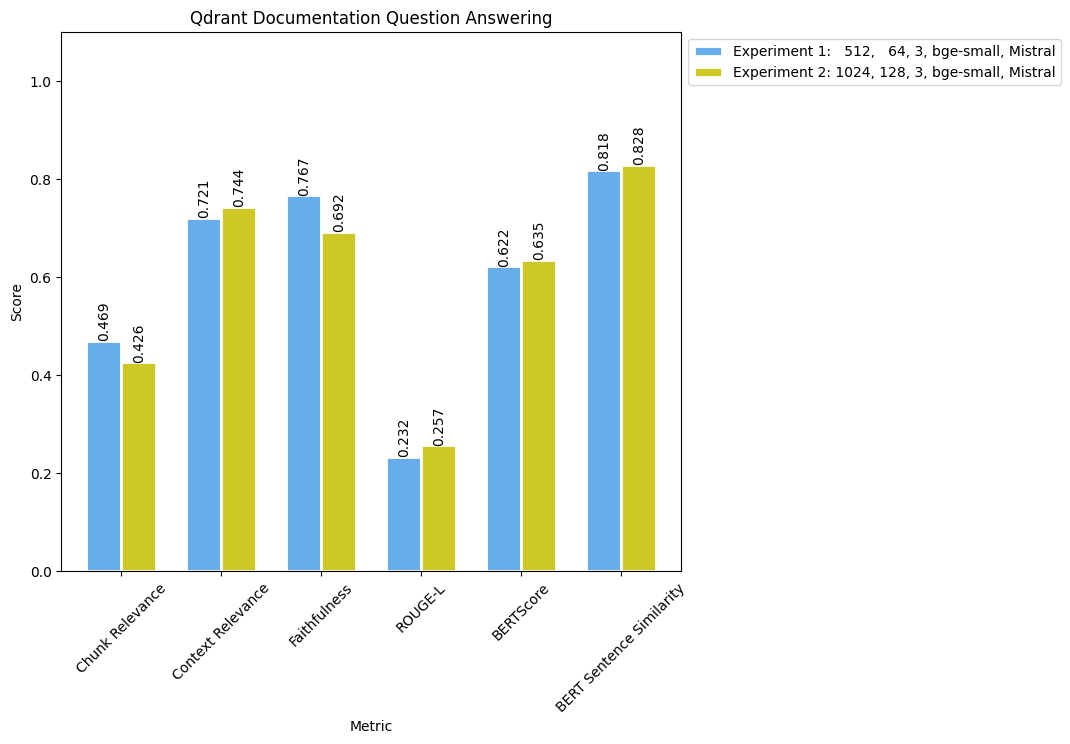

In [46]:
exp1 = ['Experiment 1:   512,   64, 3, bge-small, Mistral'] + experiment_1[main_metrics].mean().to_list()
exp2 = ['Experiment 2: 1024, 128, 3, bge-small, Mistral'] + experiment_2[main_metrics].mean().to_list()

stats = pd.DataFrame([exp1, exp2], columns=['experiment']+main_metrics)
stats = pd.pivot_table(stats, columns='experiment')
stats = stats.loc[["Chunk Relevance","Context Relevance","Faithfulness","ROUGE-L","BERTScore","BERT Sentence Similarity"]]

ax1 = stats.plot(kind='bar',
                 figsize=(8,7),
                 width=0.7, edgecolor="w", linewidth=2,
                 ylim=[0,1.1],
                 xlabel='Metric',
                 ylabel="Score",
                 title="Qdrant Documentation Question Answering",
                 color=["#65AEEA","#CEC825","#F7693C","#D8D7CA","#7D7D6C"])

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.tick_params(axis='x', rotation=45)

for container in ax1.containers:
  ax1.bar_label(container, fmt='%.3f', rotation=90)

#### **Observation** ####

You can see that by increasing the *chunk size*, we had some minor improvements in our LLM completion metrics (BERT Sentence Similarity, BERTScore, ROUGE-L, Knowledge F1). 
That said, we saw a considerable drop in *Faithfulness*, which is the metric we are optimizing for.

Of note, you can see that the *Context Relevance* increased, meaning that the RAG pipeline retrieved more of the necessary information to answer the question. 
However, you can also see that the *Chunk Relevance* dropped considerably, meaning that a smaller portion of each of the retrieved documents were actually relevant for answering the question.

**The combination of increased Context Relevance with decreased Chunk Relevance implies that if we simply retrieve more documents using the smaller chunk size, we may get better results**.

Let's test it out!

### **Experiment 3: Increasing number of documents retrieved**

This time, we are using the same RAG setup as `Experiment 1`, but increasing the number of retrieved documents from **3** to **5**.

- **Embeddings: `bge-small-en`**
- **Chunk size: `512`**
- **Chunk overlap: `64`**
- **Number of docs: `5`**
- **Language model: `Mistral-7B-Instruct`**

##### **Data preprocessing based on `configuration` above**

In [47]:
## for iteration 2 - lets modify chunk configuration
## We will start with creating seperate collection to store vectors

chunk_size=512
chunk_overlap=64
embedding_model_name="BAAI/bge-small-en"
num_docs=5

COLLECTION_NAME = f"experiment_{chunk_size}_{chunk_overlap}_{embedding_model_name.split('/')[1]}"

##### **Experiment evaluation**

In [58]:
experiment_3 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_documents,
                        recipe_id=recipe_mistral['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_mistral.csv")

Getting Completions... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Computing Metrics...   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Job completed!


/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,5702.252604,0.495340,0.755696,0.788785,0.242304,0.628401,0.828160,168.813187,2.604643
std,2716.661986,0.140528,0.258689,0.185818,0.090504,0.051675,0.108928,73.740071,1.999551
min,786.198000,0.146026,0.001468,0.241293,0.066298,0.523761,0.389116,15.000000,0.187500
25%,3400.261000,0.413530,0.637170,0.681010,0.187275,0.592282,0.779444,109.000000,1.403804
50%,5586.812000,0.505347,0.827659,0.817198,0.233216,0.631218,0.858099,161.000000,1.989899
75%,7176.652500,0.576571,0.960769,0.958603,0.289771,0.666392,0.913214,211.500000,3.265414
max,14039.767000,0.843150,0.999397,0.998628,0.598985,0.772779,0.984614,372.000000,10.789474


### **Result Comparison**
Now let's compare our results!

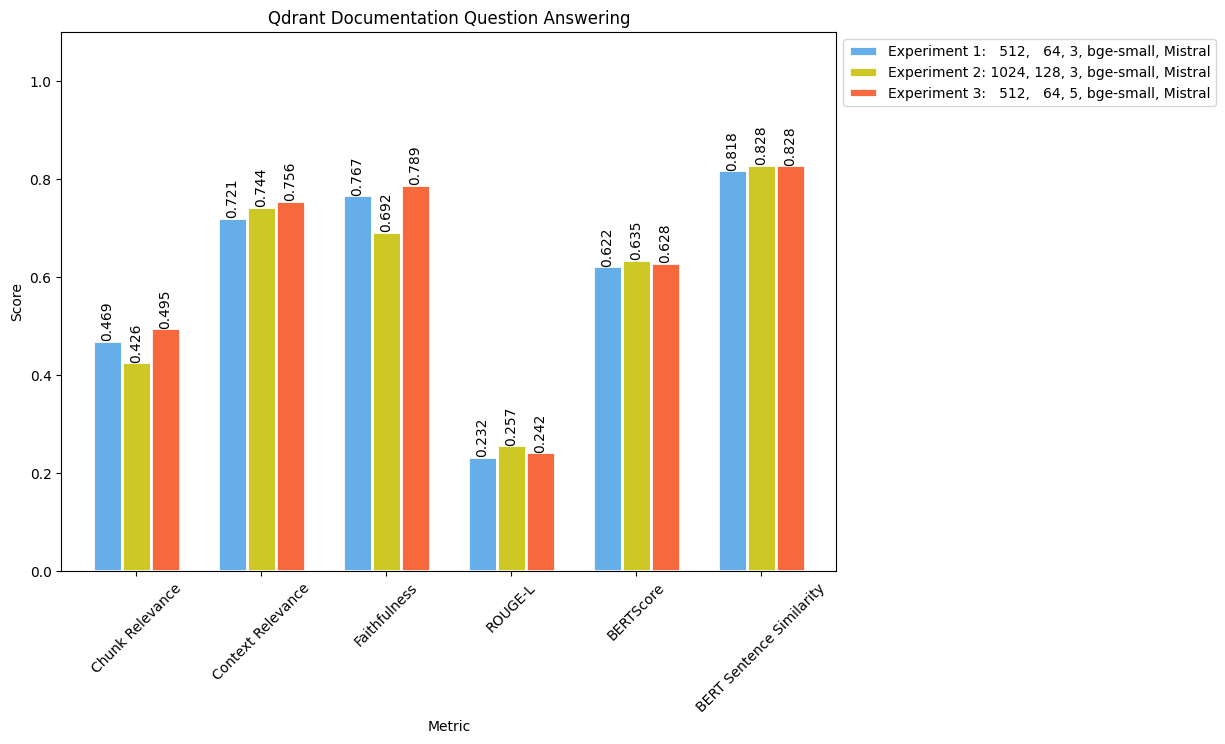

In [59]:
exp3 = ['Experiment 3:   512,   64, 5, bge-small, Mistral'] + experiment_3[main_metrics].mean().to_list()

stats = pd.DataFrame([exp1, exp2, exp3], columns=['experiment']+main_metrics)
stats = pd.pivot_table(stats, columns='experiment')
stats = stats.loc[["Chunk Relevance","Context Relevance","Faithfulness","ROUGE-L","BERTScore","BERT Sentence Similarity"]]

ax1 = stats.plot(kind='bar',
                 figsize=(10,7),
                 width=0.7, edgecolor="w", linewidth=2,
                 ylim=[0,1.1],
                 xlabel='Metric',
                 ylabel="Score",
                 title="Qdrant Documentation Question Answering",
                 color=["#65AEEA","#CEC825","#F7693C","#D8D7CA","#7D7D6C"])

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.tick_params(axis='x', rotation=45)

for container in ax1.containers:
  ax1.bar_label(container, fmt='%.3f', rotation=90)

As expected, **using the smaller chunk size but retrieving more documents** achieved both **the highest Context Relevance and the highest Chunk Relevance**. 
It also gave us the best (marginally) **Faithfulness score**, meaning that we have *a lower occurrence of hallucinations*.

### **Experiment 4: Changing the embedding model**

Before we go too deep into improving our document chunking, it is worth testing another embedding model to see if we can get better results. 
We will use the best parameters that we identified from `Experiment 3` but try a **Sentence Transformers** model instead:

- **Embeddings: `all-MiniLM-L6-v2`**
- **Chunk size: `512`**
- **Chunk overlap: `64`**
- **Number of docs: `5`**
- **Language model: `Mistral-7B-Instruct`**

##### **Data preprocessing based on `configuration` above**

In [50]:
## for iteration 3 - lets modify embedding model
## We will start with creating seperate collection to store vectors

chunk_size=512
chunk_overlap=64
embedding_model_name="sentence-transformers/all-MiniLM-L6-v2"
num_docs=5

COLLECTION_NAME = f"experiment_{chunk_size}_{chunk_overlap}_{embedding_model_name.split('/')[1]}"

add_documents(client,
              collection_name=COLLECTION_NAME,
              chunk_size=chunk_size,
              chunk_overlap=chunk_overlap,
              embedding_model_name=embedding_model_name)

processed:  4504
content:  4504
metadata:  4504


Fetching 7 files:   0%|                                                                                                                            | 0/7 [00:00<?, ?it/s]
tokenizer_config.json: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.43k/1.43k [00:00<00:00, 2.72MB/s]

special_tokens_map.json:   0%|                                                                                                                 | 0.00/695 [00:00<?, ?B/s]

config.json: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 396kB/s]

model.onnx:   0%|                                                                                                                            | 0.00/90.4M [00:00<?, ?B/s]

vocab.txt:   0%|                                                                                                                              | 0.

##### **Experiment evaluation**

In [51]:
experiment_4 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_documents,
                        recipe_id=recipe_mistral['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_mistral.csv")


Getting Completions... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Computing Metrics...   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Job completed!


/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,3910.557286,0.462717,0.661327,0.728665,0.244296,0.627851,0.803586,169.967033,2.723265
std,2210.989126,0.183200,0.291964,0.206338,0.103818,0.057855,0.135976,84.750411,2.446781
min,872.227000,0.024833,0.003442,0.266475,0.062893,0.474121,0.302162,15.000000,0.357143
25%,2048.553000,0.346857,0.481222,0.544587,0.167893,0.589717,0.754533,96.500000,1.173389
50%,3755.477000,0.446703,0.696171,0.751593,0.235294,0.628372,0.829773,161.000000,2.027027
75%,4873.187000,0.594996,0.950215,0.935752,0.301075,0.661741,0.902050,223.500000,3.533570
max,14017.769000,0.876302,0.998721,0.998825,0.593750,0.797422,0.976734,405.000000,15.631579


### **Result Comparison**

Let's compare our results!

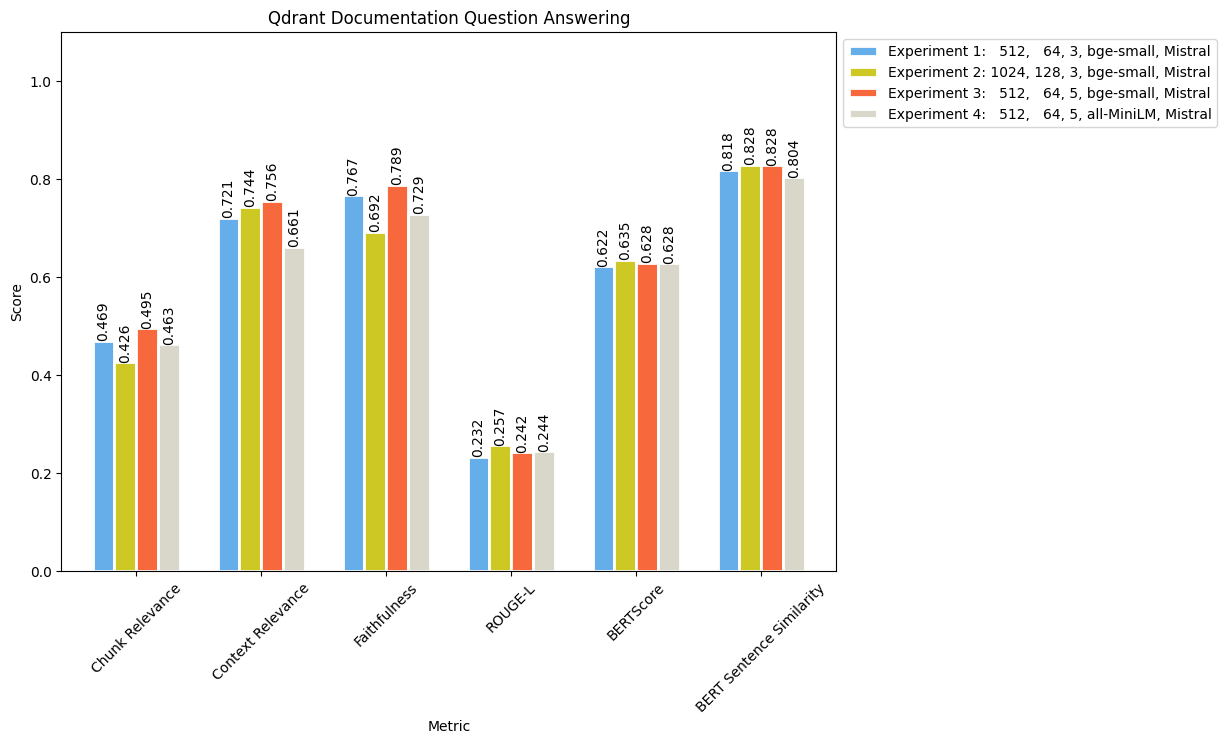

In [60]:
exp4 = ['Experiment 4:   512,   64, 5, all-MiniLM, Mistral'] + experiment_4[main_metrics].mean().to_list()

stats = pd.DataFrame([exp1, exp2, exp3, exp4], columns=['experiment']+main_metrics)
stats = pd.pivot_table(stats, columns='experiment')
stats = stats.loc[["Chunk Relevance","Context Relevance","Faithfulness","ROUGE-L","BERTScore","BERT Sentence Similarity"]]

ax1 = stats.plot(kind='bar',
                 figsize=(10,7),
                 width=0.7, edgecolor="w", linewidth=2,
                 ylim=[0,1.1],
                 xlabel='Metric',
                 ylabel="Score",
                 title="Qdrant Documentation Question Answering",
                 color=["#65AEEA","#CEC825","#F7693C","#D8D7CA","#7D7D6C"])

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.tick_params(axis='x', rotation=45)

for container in ax1.containers:
  ax1.bar_label(container, fmt='%.3f', rotation=90)

It seems that `bge-small` *was better able to capture the semantic meaning of the Qdrant Documentation*.

### **Experiment 5: Changing the LLM**

So far, we've only experimented with the retrieval side of our RAG pipeline. 
Let's try changing the LLM, keeping the best parameters from `Experiment 3`:

- **Embeddings: `bge-small-en`**
- **Chunk size: `512`**
- **Chunk overlap: `64`**
- **Number of docs: `5`**
- **Language model: `GPT-3.5-turbo`**

##### **Data preprocessing based on `configuration` above**

In [296]:
chunk_size=512
chunk_overlap=64
embedding_model_name="BAAI/bge-small-en"
num_docs=5

COLLECTION_NAME = f"experiment_{chunk_size}_{chunk_overlap}_{embedding_model_name.split('/')[1]}"
client.set_model(embedding_model_name=embedding_model_name)

##### **Create a recipe for the generator model and prompt template**

We'll then take our evaluation dataset and test out a recipe for question-answering on a **GPT-3.5-turbo** model.

In [43]:
# First, we have to create a recipe using the same prompt template and GPT-3.5-turbo
recipe_gpt = quotient.create_recipe(
    model_id=5,
    prompt_template_id=1,
    name='gpt3.5-qa-with-rag-recipe-v1',
    description='GPT-3.5 using a prompt template that includes context.'
)

recipe_gpt

{'id': 586,
 'name': 'gpt3.5-qa-with-rag-recipe-v1',
 'description': 'GPT-3.5 using a prompt template that includes context.',
 'model_id': 5,
 'prompt_template_id': 1,
 'created_at': '2024-06-19T03:48:13.899887',
 'owner_profile_id': 14,
 'system_prompt_id': None,
 'prompt_template': {'id': 1,
  'name': 'Default Question Answering Template',
  'variables': '["input_text","context"]',
  'created_at': '2023-12-21T22:01:54.632367',
  'template_string': 'Question: {input_text}\\n\\nContext: {context}\\n\\nAnswer:',
  'owner_profile_id': None},
 'model': {'id': 5,
  'name': 'gpt-3.5-turbo',
  'endpoint': 'https://api.openai.com/v1/chat/completions',
  'revision': 'placeholder',
  'created_at': '2024-02-06T17:01:21.408454',
  'model_type': 'OpenAI',
  'description': 'Returns a maximum of 4K output tokens.',
  'owner_profile_id': None,
  'external_model_config_id': None,
  'instruction_template_cls': 'NoneType'}}

##### **Experiment evaluation**

In [55]:

experiment_5 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_documents,
                        recipe_id=recipe_gpt['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_reranked_gpt.csv")


Getting Completions... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Computing Metrics...   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Job completed!


/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/y_/kgpwc3b54fng37vrg6bwt7nr0000gn/T/ipykernel_14222/1334780989.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,4056.981560,0.495340,0.755696,0.809529,0.291575,0.652713,0.841584,144.131868,2.186067
std,1981.425665,0.140528,0.258689,0.205159,0.117402,0.055585,0.105432,68.102897,1.746794
min,679.466000,0.146026,0.001468,0.039711,0.065306,0.535601,0.348400,11.000000,0.154930
25%,2611.284500,0.413530,0.637170,0.710481,0.206693,0.609936,0.792854,98.000000,1.242745
50%,3940.502000,0.505347,0.827659,0.882219,0.273810,0.654279,0.858443,141.000000,1.869919
75%,5239.077500,0.576571,0.960769,0.965920,0.343473,0.684130,0.924669,192.000000,2.641022
max,11985.503000,0.843150,0.999397,0.999471,0.653061,0.787585,0.991066,292.000000,12.315789


### **Result Comparison**

Let's compare our results!

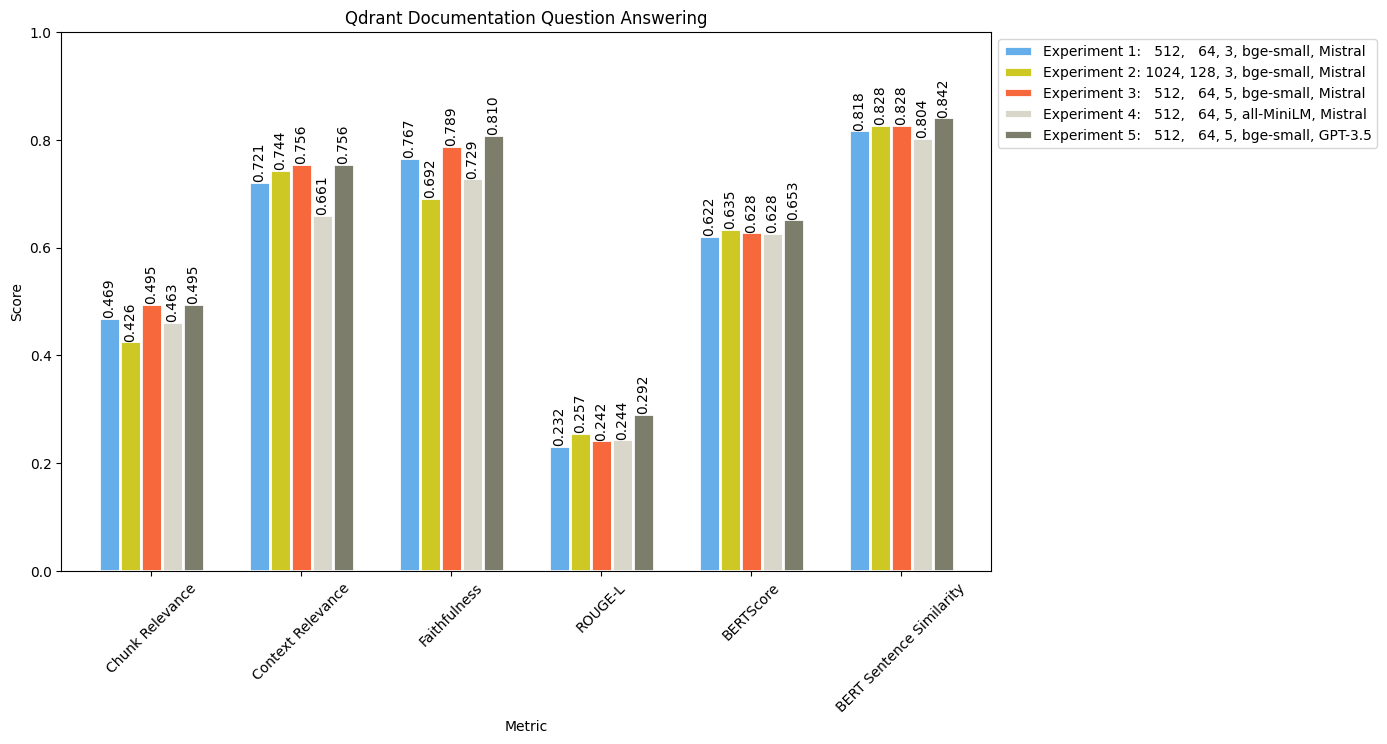

In [61]:
exp5 = ['Experiment 5:   512,   64, 5, bge-small, GPT-3.5'] + experiment_5[main_metrics].describe().loc['mean'].to_list()

stats = pd.DataFrame([exp1, exp2, exp3, exp4, exp5], columns=['experiment']+main_metrics)
stats = pd.pivot_table(stats, columns='experiment')
stats = stats.loc[["Chunk Relevance","Context Relevance","Faithfulness","ROUGE-L","BERTScore","BERT Sentence Similarity"]]

ax1 = stats.plot(kind='bar',
                 figsize=(12,7),
                 width=0.7, edgecolor="w", linewidth=2,
                 ylim=[0,1],
                 xlabel='Metric',
                 ylabel="Score",
                 title="Qdrant Documentation Question Answering",
                 color=["#65AEEA","#CEC825","#F7693C","#D8D7CA","#7D7D6C"])

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.tick_params(axis='x', rotation=45)

for container in ax1.containers:
  ax1.bar_label(container, fmt='%.3f', rotation=90)

**GPT-3.5 outdid Mistral-7B** across all metrics! 
Most importantly, **Experiment 5 has the lowest prevalence of hallucination**.


In [368]:
with pd.option_context('display.max_colwidth', 1500):
    display(experiment_5[['content.input_text', 'content.answer','content.documents','Chunk Relevance','Context Relevance','Faithfulness']
                ].sort_values(by='Faithfulness').head(3))

,content.input_text,content.answer,content.documents,Chunk Relevance,Context Relevance,Faithfulness
67,What does Qdrant not plan to support in the future?,"In the future, Qdrant does not plan to support BM25 or other non-vector-based retrieval or ranking functions, built-in ontologies or knowledge graphs, and query analyzers and other NLP tools. Qdrant aims to introduce support for sparse vectors, as used in SPLADE or similar models, but does not intend to incorporate the aforementioned features into its functionality. Users can combine Qdrant with specialized tools, including full-text search engines, to complement its capabilities.","[## Why Qdrant?, ## What sets Qdrant apart?, You acknowledge that you are informed that the unavailability of the Solution may be the result of (a) a maintenance operation, (b) an urgent operation relating in particular to security, (c) a case of “force majeure” or (d) the malfunctioning of computer applications of Qdrant's third-party partners. Qdrant undertakes to restore the availability of the Solution as soon as possible once the problem causing the unavailability has been resolved., You further declare and guarantee that by creating, installing, downloading or transmitting the Content through the Solution, you do not infringe third parties’ rights.\n\n\n\nYou acknowledge and accept that Qdrant cannot be held responsible for the Content.\n\n\n\n### 9. Accessibility of the Solution, To keep the human in the loop.\n\nBut obviously some stuff that are on our roadmap.\n\nAnd another thing that we don't support, which is one type of action would.\n\nBe the first we will be working on is obviously code interpretation, which is I think is one of the things that all users ask because they use.\n\nIt on Chat GPT.\n\nAnd so we'll be looking into that as well.\n\n\n\n\n\nDemetrios:\n\nWhat made you choose Qdrant?\n\n\n\n\n\nStanislas Polu:\n\nSo the decision was made, if I.]",0.179669,0.352515,0.039711
54,What is the default scoring metric used in Qdrant for search operations?,"The default scoring metric used in Qdrant for search operations is `Dot product`. It is not necessary to specify this metric explicitly as it is the default setting. However, Qdrant also supports other distance metrics such as Cosine for scoring. When performing a search operation in Qdrant, if no specific metric is mentioned, the system will automatically use the Dot product as the scoring metric.","[qdrant: &QdrantClient,\n\n) -> Result<Vec<ScoredPoint>> {\n\n Ok(qdrant.search_points(&SearchPoints {\n\n collection_name,\n\n limit: 5, // use what fits your use case here\n\n with_payload: Some(true.into()),\n\n vector: embed(client, text, api_key)?,\n\n ..Default::default()\n\n }).await?.result)\n\n}\n\n```, let search_result = client\n\n .search_points(&SearchPoints {\n\n collection_name: ""test_collection"".to_string(),\n\n vector: vec![0.2, 0.1, 0.9, 0.7],\n\n filter: Some(Filter::all([Condition::matches(\n\n ""city"",\n\n ""London"".to_string(),\n\n )])),\n\n limit: 2,\n\n ..Default::default()\n\n })\n\n .await?;\n\n\n\ndbg!(search_result);\n\n```\n\n\n\n```java\n\nimport static io.qdrant.client.ConditionFactory.matchKeyword;\n\n\n\nList<ScoredPoint> searchResult =\n\n client, to do it. \n\n\n\n## Wrapping up\n\n\n\nAssessing the quality of retrieval is a critical aspect of evaluating semantic search performance. It is imperative to measure retrieval quality when aiming for optimal quality of.\n\nyour search results. Qdrant provides a built-in exact search mode, which can be used to measure the quality of the ANN algorithm itself, \n\neven in an automated way, as part of your CI/CD pipeline., * Evaluation of results size for faceted search\n\n* Determining the number of pages for pagination\n\n* Debugging the query execution speed\n\n\n\nREST API ([Schema...",0.415677,0.029021,0.086533
44,What parameters can be configured in the configuration file to improve performance in HNSW indexing?,"In the context of HNSW indexing, th

### **Conclusions from Naive RAG hyperparameter optimizations**

The table below summarizes the parameters tested and their results across our 5 experiments:

In [57]:
results = pd.DataFrame([exp1, exp2, exp3, exp4, exp5], columns=['experiment']+main_metrics)
results[['chunk size', 'chunk overlap', 'num docs', 'embedding model','LLM']] = results.experiment.str.split(':').str[1].str.split(',', expand=True)

display(results[['chunk size', 'chunk overlap', 'num docs', 'embedding model','LLM']+main_metrics])

,chunk size,chunk overlap,num docs,embedding model,LLM,Context Relevance,Chunk Relevance,Faithfulness,ROUGE-L,BERT Sentence Similarity,BERTScore
0,512,64,3,bge-small,Mistral,0.721464,0.469500,0.766502,0.232352,0.817773,0.621800
1,1024,128,3,bge-small,Mistral,0.743847,0.425984,0.691954,0.256553,0.828487,0.635432
2,512,64,5,bge-small,Mistral,0.755696,0.495340,0.758635,0.252953,0.828916,0.628497
3,512,64,5,all-MiniLM,Mistral,0.661327,0.462717,0.728665,0.244296,0.803586,0.627851
4,512,64,5,bge-small,GPT-3.5,0.755696,0.495340,0.809529,0.291575,0.841584,0.652713


There are certainly more experiments to run - we still have generally poor performance on the *retrieval side* of RAG. 
We may want to *explore different embedding models*, or *different retrieval strategies*. 

>The large variances in Context Relevance imply that some questions may require more documents than others, so a dynamic retrieval strategy may be worth investigating.

There is always more exploration to be done on the generative side of RAG as well - changing up LLMs or prompts can have a big influence on the overall quality of responses.

### **Experiment 6 : Adding Reranking - Mixedbread.ai**

Let's try adding `reranking` , keeping the best parameters from `Experiment 5`:

- **Embeddings: `bge-small-en`**
- **Chunk size: `512`**
- **Chunk overlap: `64`**
- **Number of docs: `5`**
- **Language model: `GPT-3.5-turbo`**
- **Reranking model: `mixedbread-ai/mxbai-rerank-large-v1`**

In [315]:
experiment_6 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_reranked_documents_with_mixedbread,
                        recipe_id=recipe_gpt['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_reranked_mixedbread_gpt.csv")

Output()

Output()

Job completed!


/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/3208309348.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/3208309348.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,3547.150967,0.490597,0.785544,0.824394,0.288392,0.649738,0.849143,141.527473,2.203467
std,1561.694500,0.137763,0.240843,0.174948,0.110485,0.058414,0.113893,64.621864,1.748347
min,688.772000,0.173024,0.002279,0.204119,0.075472,0.526889,0.372833,14.000000,0.215385
25%,2477.692500,0.394889,0.651751,0.684990,0.221529,0.616922,0.806785,99.500000,1.134988
50%,3375.214000,0.493494,0.863257,0.882506,0.271062,0.657554,0.871017,133.000000,1.657895
75%,4260.570000,0.586168,0.972695,0.979463,0.355736,0.682276,0.929619,182.500000,2.866928
max,7277.937000,0.780893,0.999267,0.999442,0.721311,0.844924,0.988861,295.000000,10.421053


With reranking incorporated, you can see that our lowest scores for Faithfulness went from 0.04 to 0.4 - an order of magnitude improvement. 

Furthermore, the two lowest performing datapoints for our Naive RAG implementation in Experiment 5 significantly improved performance after incorporating reranking. 

### **Experiment 7 : Adding Reranking - Cohere**

Let's try adding `reranking` , keeping the best parameters from `Experiment 5`:

- **Embeddings: `bge-small-en`**
- **Chunk size: `512`**
- **Chunk overlap: `64`**
- **Number of docs: `5`**
- **Language model: `GPT-3.5-turbo`**
- **Reranking model: `rerank-english-v3.0`**

In [316]:
experiment_7 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_reranked_documents_with_cohere,
                        recipe_id=recipe_gpt['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_reranked_cohere_gpt.csv")


Output()

Output()

Job completed!


/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/3208309348.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/3208309348.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,3621.953571,0.502324,0.793897,0.834533,0.292739,0.650726,0.846161,146.813187,2.339074
std,1487.688621,0.129882,0.242294,0.169295,0.122754,0.059818,0.118109,60.320977,2.007297
min,560.923000,0.220292,0.004120,0.092726,0.058537,0.503307,0.348400,11.000000,0.154930
25%,2390.815000,0.403505,0.647707,0.745182,0.208953,0.605839,0.809400,98.000000,1.209588
50%,3644.591000,0.505981,0.884195,0.867707,0.273063,0.653925,0.873476,147.000000,1.819444
75%,4657.496000,0.591213,0.985435,0.979754,0.360443,0.687629,0.928054,194.500000,2.732738
max,7744.302000,0.771028,0.999734,0.999202,0.721311,0.844924,0.991066,280.000000,11.421053


### **Experiment 8 : Adding Reranking - Jina**

Let's try adding `reranking` , keeping the best parameters from `Experiment 5`:

- **Embeddings: `bge-small-en`**
- **Chunk size: `512`**
- **Chunk overlap: `64`**
- **Number of docs: `5`**
- **Language model: `GPT-3.5-turbo`**
- **Reranking model: `jina-reranker-v1-base-en`**

In [335]:
experiment_8 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_reranked_documents_with_jina,
                        recipe_id=recipe_gpt['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_reranked_jina_colbert_gpt.csv")

Output()

Output()

Job completed!


/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/3208309348.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/3208309348.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,3257.089912,0.480759,0.776272,0.803262,0.287293,0.650255,0.841771,144.252747,2.286892
std,1516.335797,0.128977,0.254527,0.186789,0.112139,0.058230,0.126879,68.125308,2.011351
min,578.223000,0.236695,0.001783,0.108184,0.058537,0.518993,0.341379,11.000000,0.154930
25%,2018.138500,0.378134,0.638265,0.691523,0.208625,0.612297,0.798605,94.000000,1.178166
50%,3036.612000,0.471806,0.854213,0.828077,0.282209,0.658068,0.882345,132.000000,1.750000
75%,4253.010500,0.563805,0.979261,0.970493,0.364703,0.688178,0.928468,188.500000,2.475742
max,7902.205000,0.743409,0.999718,0.999519,0.631579,0.796175,0.985323,329.000000,12.368421


### **Comparing the Reranker effect on the RAG Pipeline**


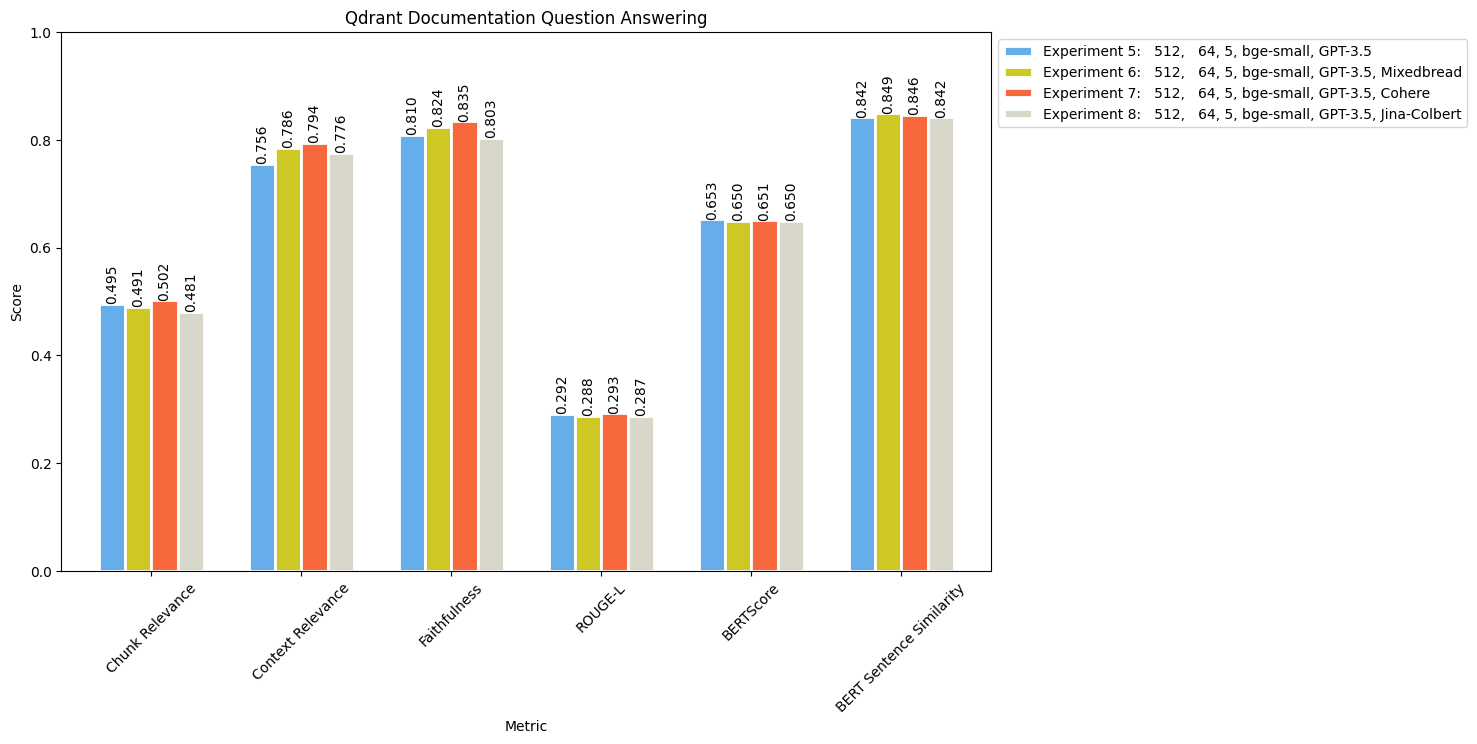

In [337]:
exp5 = ['Experiment 5:   512,   64, 5, bge-small, GPT-3.5'] + experiment_5[main_metrics].describe().loc['mean'].to_list()
exp6 = ['Experiment 6:   512,   64, 5, bge-small, GPT-3.5, Mixedbread'] + experiment_6[main_metrics].describe().loc['mean'].to_list()
exp7 = ['Experiment 7:   512,   64, 5, bge-small, GPT-3.5, Cohere'] + experiment_7[main_metrics].describe().loc['mean'].to_list()
exp8 = ['Experiment 8:   512,   64, 5, bge-small, GPT-3.5, Jina-Colbert'] + experiment_8[main_metrics].describe().loc['mean'].to_list()

stats = pd.DataFrame([exp5, exp6, exp7, exp8], columns=['experiment']+main_metrics)
stats = pd.pivot_table(stats, columns='experiment')
stats = stats.loc[["Chunk Relevance","Context Relevance","Faithfulness","ROUGE-L","BERTScore","BERT Sentence Similarity"]]

ax1 = stats.plot(kind='bar',
                 figsize=(12,7),
                 width=0.7, edgecolor="w", linewidth=2,
                 ylim=[0,1],
                 xlabel='Metric',
                 ylabel="Score",
                 title="Qdrant Documentation Question Answering",
                 color=["#65AEEA","#CEC825","#F7693C","#D8D7CA","#7D7D6C"])

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.tick_params(axis='x', rotation=45)

for container in ax1.containers:
  ax1.bar_label(container, fmt='%.3f', rotation=90)

In [375]:
print("Minimum Faithfulness scores for Naive RAG vs. Reranking with Cohere:\n")
print('Top Naive RAG Implementation: ',experiment_5.Faithfulness.min())
print('Reranking (Cohere) Implementation: ',experiment_7.Faithfulness.min())

with pd.option_context('display.max_colwidth', 0):
    display(experiment_7.loc[[67,54]][['content.input_text', 'content.answer','content.documents','Chunk Relevance','Context Relevance','Faithfulness']
                ].sort_values(by='Faithfulness').head(2))

Minimum Faithfulness scores for Naive RAG vs. Reranking with Cohere:

Top Naive RAG Implementation:  0.0397113561630249
Reranking (Cohere) Implementation:  0.09272611141204834


,content.input_text,content.answer,content.documents,Chunk Relevance,Context Relevance,Faithfulness
67,What does Qdrant not plan to support in the future?,"In the future, Qdrant does not plan to support BM25 or other non-vector-based retrieval or ranking functions, built-in ontologies or knowledge graphs, and query analyzers and other NLP tools. Qdrant aims to introduce support for sparse vectors, as used in SPLADE or similar models, but does not intend to incorporate the aforementioned features into its functionality. Users can combine Qdrant with specialized tools, including full-text search engines, to complement its capabilities.","[To keep the human in the loop.\n\nBut obviously some stuff that are on our roadmap.\n\nAnd another thing that we don't support, which is one type of action would.\n\nBe the first we will be working on is obviously code interpretation, which is I think is one of the things that all users ask because they use.\n\nIt on Chat GPT.\n\nAnd so we'll be looking into that as well.\n\n\n\n\n\nDemetrios:\n\nWhat made you choose Qdrant?\n\n\n\n\n\nStanislas Polu:\n\nSo the decision was made, if I., Other than as expressly set out in these terms, Qdrant does not make any commitments about the Solution and Website’s availability or ability to meet your expectations.\n\n\n\n\n\n### 15. Liability\n\n\n\nIn no event shall Qdrant be liable for:\n\n\n\n\n\n* any indirect damages of any kind, including any potential loss of business;\n\n* any damage or loss which is not caused by a breach of its obligations under the T&Cs;\n\n* disruptions or damage inherent in an electronic communications network;, Qdrant undertakes, in particular, to carry out regular checks to verify the operation and accessibility of the Solution. In this regard, Qdrant reserves the right to interrupt access to the Solution momentarily for reasons of maintenance. Similarly, Qdrant may not be held responsible for momentary difficulties or impossibilities in accessing the Solution and/or Website, the origin of which is external to it, “force majeure”, or which are due to disruptions in the telecommunications network., * unauthorized access to the Solution by a third-party caused by you, including through your negligence;\n\n* your failure to fulfill your obligations under the T&Cs;\n\n* implementation of any software package, software or operating system not compatible with the Solution;\n\n* failure of the electronic communication networks which is not the fault of Qdrant;\n\n* your refusal to collaborate with Qdrant in the resolution of the anomalies and in particular to answer questions and requests for information;, Demetrios:\n\nYeah, I think it's more just like you don't have to add it on to Qdrant in any way or this is completely separated.\n\n\n\nNirant Kasliwal:]",0.388298,0.615873,0.092726
54,What is the default scoring metric used in Qdrant for search operations?,"The default scoring metric used in Qdrant for search operations is `Dot product`. It is not necessary to specify this metric explicitly as it is the default setting. However, Qdrant also supports other distance metrics such as Cosine for scoring. When performing a search operation in Qdrant, if no specific metric is mentioned, the system will automatically use the Dot product as the scoring metric.","[| Index| Sparse Query | Dense Query |\n\n| --- | --- | --- | \n\n| Scoring Metric | Default is `Dot product`, no need to specify it | `Distance` has supported metrics e.g. Dot, Cosine |\n\n| Search Type | Always exact in Qdrant | HNSW is an approximate NN |\n\n| Return Behaviour | Returns only vectors with non-zero values in the same indices as the query vector | Returns `limit` vectors |\n\n\n\nIn general, the speed of the search is proportional to the number of non-zero values in the query vector.\n\n\n\n```http, qdrant: &QdrantClient,\n\n) -> Result<Vec<ScoredPoint>> {\n\n Ok(qdrant.search_points(&SearchPoints {\n\n collection_name,\n\n limit: 5, // use what fits your use ca

Incorporating Reranking into our RAG solution had mixed results. For the most part, the rerankers did not improve our overall performance - all rerankers had lower chunk and context relevances, and lower ROUGE and BERT metrics. However, using Cohere as a re-ranker resulted in significantly `improved Faithfulness` scores. 

### **Experiment 9 : Adding Multivector - Dense and Sparse Vectors**

Let's try adding `hybrid` vector strategy , keeping the best parameters from `Experiment 5`:

- **Dense Embedding model: `bge-small-en`**
- **Sparse Embedding model: `prithivida/Splade_PP_en_v1`**
- **Chunk size: `512`**
- **Chunk overlap: `64`**
- **Number of docs: `5`**
- **Language model: `GPT-3.5-turbo`**


In [58]:
## We will start with creating seperate collection to store hybrid vectors

chunk_size=512
chunk_overlap=64
embedding_model_name="BAAI/bge-small-en"
num_docs=5


COLLECTION_NAME = f"hybrid_experiment_{chunk_size}_{chunk_overlap}_{embedding_model_name.split('/')[1]}"
client.set_model(embedding_model_name=embedding_model_name)
Settings.embed_model = FastEmbedEmbedding(model_name=embedding_model_name)

add_hybrid_documents(client,
              collection_name=COLLECTION_NAME,
              chunk_size=chunk_size,
              chunk_overlap=chunk_overlap,
              embedding_model_name=embedding_model_name)

In [87]:
HYBRID_FACTOR=0.4

experiment_9 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_hybrid_documents,
                        recipe_id=recipe_gpt['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_hybrid_gpt.csv")


Output()

Output()

Job completed!


/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/1942828997.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/1942828997.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,3511.402505,0.500447,0.780795,0.810670,0.301904,0.658590,0.849098,141.824176,2.241019
std,1694.686976,0.141868,0.245517,0.180436,0.117524,0.062869,0.103901,61.925510,1.818712
min,667.401000,0.159945,0.003996,0.384500,0.086538,0.526043,0.441497,14.000000,0.215385
25%,2301.597000,0.415434,0.685290,0.684783,0.215972,0.611762,0.798799,97.500000,1.204275
50%,3269.370000,0.511817,0.864134,0.864633,0.297674,0.662189,0.864607,131.000000,1.640000
75%,4318.999000,0.576945,0.975862,0.975517,0.368878,0.701881,0.934408,187.500000,2.537671
max,8830.000000,0.862795,0.999734,0.999461,0.698630,0.854854,0.991066,302.000000,10.315789


### **Comparing the results of our experiments so far**


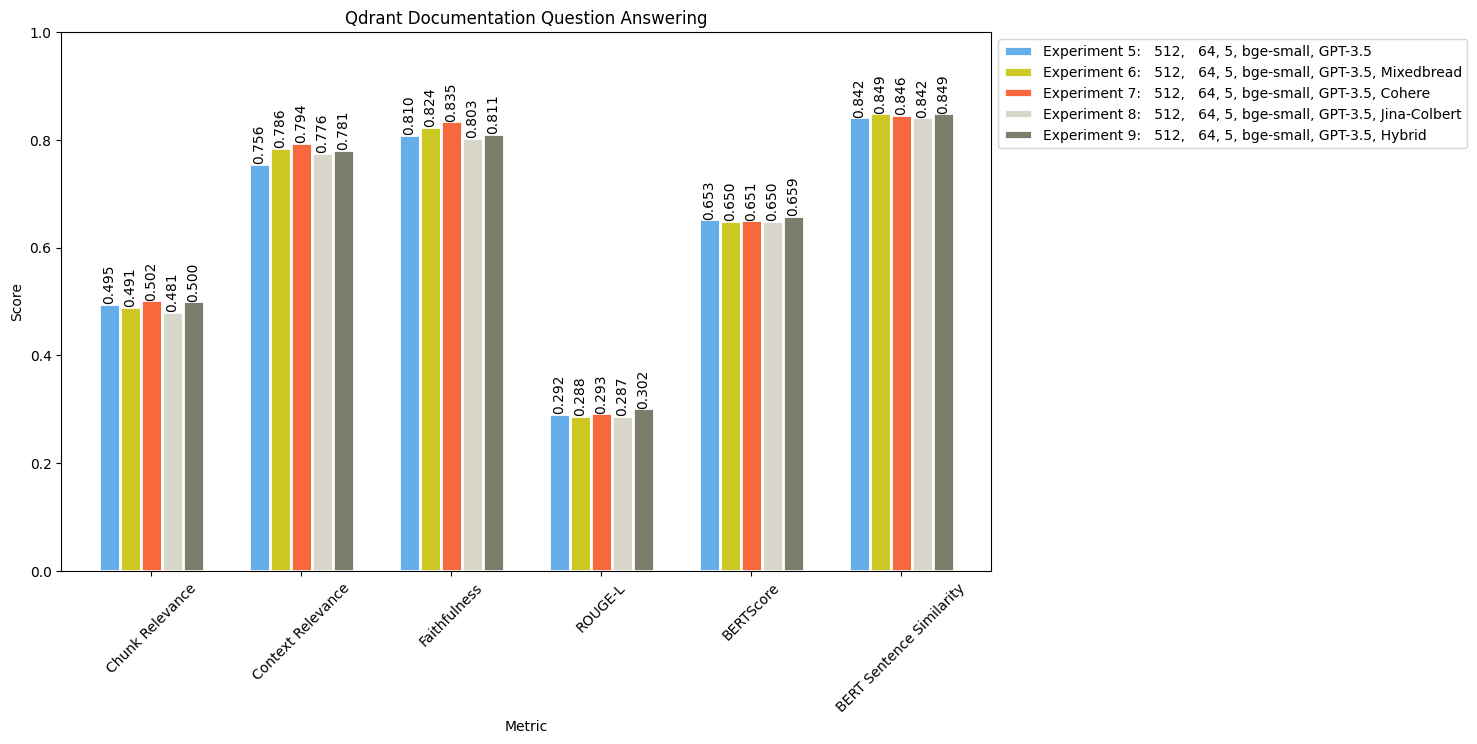

In [339]:
exp9 = ['Experiment 9:   512,   64, 5, bge-small, GPT-3.5, Hybrid'] + experiment_9[main_metrics].describe().loc['mean'].to_list()

stats = pd.DataFrame([exp5, exp6, exp7, exp8, exp9], columns=['experiment']+main_metrics)
stats = pd.pivot_table(stats, columns='experiment')
stats = stats.loc[["Chunk Relevance","Context Relevance","Faithfulness","ROUGE-L","BERTScore","BERT Sentence Similarity"]]

ax1 = stats.plot(kind='bar',
                 figsize=(12,7),
                 width=0.7, edgecolor="w", linewidth=2,
                 ylim=[0,1],
                 xlabel='Metric',
                 ylabel="Score",
                 title="Qdrant Documentation Question Answering",
                 color=["#65AEEA","#CEC825","#F7693C","#D8D7CA","#7D7D6C"])

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.tick_params(axis='x', rotation=45)

for container in ax1.containers:
  ax1.bar_label(container, fmt='%.3f', rotation=90)

In [357]:
print("Minimum Faithfulness scores for Naive RAG vs. Hybrid Search:\n")
print('Top Naive RAG Implementation: ',experiment_5.Faithfulness.min())
print('Top Reranked RAG Implementation: ',experiment_7.Faithfulness.min())
print('Hybrid Search Implementation: ',experiment_9.Faithfulness.min())

with pd.option_context('display.max_colwidth', 0):
    display(experiment_9.loc[[67,54]][['content.input_text', 'content.answer','content.documents','Chunk Relevance','Context Relevance','Faithfulness']
                ].sort_values(by='Faithfulness').head(2))

Minimum Faithfulness scores for Naive RAG vs. Hybrid Search:

Top Naive RAG Implementation:  0.0397113561630249
Top Reranked RAG Implementation:  0.09272611141204834
Hybrid Search Implementation:  0.3844997389242053


,content.input_text,content.answer,content.documents,Chunk Relevance,Context Relevance,Faithfulness
67,What does Qdrant not plan to support in the future?,"In the future, Qdrant does not plan to support BM25 or other non-vector-based retrieval or ranking functions, built-in ontologies or knowledge graphs, and query analyzers and other NLP tools. Qdrant aims to introduce support for sparse vectors, as used in SPLADE or similar models, but does not intend to incorporate the aforementioned features into its functionality. Users can combine Qdrant with specialized tools, including full-text search engines, to complement its capabilities.","[What Qdrant plans to introduce in the future:\n\n\n\n- Support for sparse vectors, as used in [SPLADE](https://github.com/naver/splade) or similar models\n\n\n\nWhat Qdrant doesn't plan to support:\n\n\n\n- BM25 or other non-vector-based retrieval or ranking functions\n\n- Built-in ontologies or knowledge graphs\n\n- Query analyzers and other NLP tools\n\n\n\nOf course, you can always combine Qdrant with any specialized tool you need, including full-text search engines., Other than as expressly set out in these terms, Qdrant does not make any commitments about the Solution and Website’s availability or ability to meet your expectations.\n\n\n\n\n\n### 15. Liability\n\n\n\nIn no event shall Qdrant be liable for:\n\n\n\n\n\n* any indirect damages of any kind, including any potential loss of business;\n\n* any damage or loss which is not caused by a breach of its obligations under the T&Cs;\n\n* disruptions or damage inherent in an electronic communications network;, ## What sets Qdrant apart?, . In the default build configuration, qdrant does not include support for all languages, due to the increasing size of the resulting binary. Chinese, Japanese and Korean languages are not enabled by default, but can be enabled by building qdrant from source with `--features multiling-chinese,multiling-japanese,multiling-korean` flags., . |]",0.642882,0.950594,0.981192
54,What is the default scoring metric used in Qdrant for search operations?,"The default scoring metric used in Qdrant for search operations is `Dot product`. It is not necessary to specify this metric explicitly as it is the default setting. However, Qdrant also supports other distance metrics such as Cosine for scoring. When performing a search operation in Qdrant, if no specific metric is mentioned, the system will automatically use the Dot product as the scoring metric.","[| Index| Sparse Query | Dense Query |\n\n| --- | --- | --- | \n\n| Scoring Metric | Default is `Dot product`, no need to specify it | `Distance` has supported metrics e.g. Dot, Cosine |\n\n| Search Type | Always exact in Qdrant | HNSW is an approximate NN |\n\n| Return Behaviour | Returns only vectors with non-zero values in the same indices as the query vector | Returns `limit` vectors |\n\n\n\nIn general, the speed of the search is proportional to the number of non-zero values in the query vector.\n\n\n\n```http, qdrant: &QdrantClient,\n\n) -> Result<Vec<ScoredPoint>> {\n\n Ok(qdrant.search_points(&SearchPoints {\n\n collection_name,\n\n limit: 5, // use what fits your use case here\n\n with_payload: Some(true.into()),\n\n vector: embed(client, text, api_key)?,\n\n ..Default::default()\n\n }).await?.result)\n\n}\n\n```, let search_result = client\n\n .search_points(&SearchPoints {\n\n collection_name: ""test_collection"".to_string(),\n\n vector: vec![0.2, 0.1, 0.9, 0.7],\n\n filter: Some(Filter::all([Condition::matches(\n\n ""city"",\n\n ""London"".to_string(),\n\n )])),\n\n limit: 2,\n\n ..Default::default()\n\n })\n\n .await?;\n\n\n\ndbg!(search_result);\n\n```\n\n\n\n```java\n\nimport static io.qdrant.client.ConditionFactory.matchKeyword;\n\n\n\nList<ScoredPoint> searchResult =\n\n client, # [ScoredPoint(id=3, version=0, score=0.09, \n\n# payload=None, vector=[0.0, 0.0, 0.0, 0.1]),\n\n# ScoredPoint(id=1, version=0, score=0.10049876, \n\n# payload=None, vector=[0.0, 

It is clear that the `hybrid search approach including sparse vectors made a big difference on the quality of documents retrieved`. 
This RAG implementation achieves the highest scores for all metrics except for Faithfulness, which still outperforms the Naive RAG implementation. 

Although the Cohere reranker implementation returned the highest average Faithfulness, given the fact that hybrid search is superior in all other metrics, it is worth further exploring and optimizing this approach. 

It may be worth experimenting further by combining the `reranker with the hybrid search approach` to leverage the advantages of both methods. 
Additionally, there is still significant potential for `further experimentation on the model and prompt`, which could substantially boost metrics performance when better tailored to the Qdrant Documentation use case.

### **Experiment 10: Hybrid Search + Reranking**

Let's experiment with combining the reranker with the hybrid search approach to validate our hypothesis.

In [355]:
def get_reranked_documents_with_cohere_hybrid(collection_name, query, num_documents=5):
    """
    This function retrieves the desired number of documents from the Qdrant collection given a query.
    It returns a list of the reranked retrieved documents.
    """

    results = get_hybrid_documents(
        collection_name=collection_name, 
        query=query, 
        num_documents=num_documents+3
        )
    
    response = co.rerank(
    model="rerank-english-v3.0",
    query=query,
    documents=results,
    top_n=num_documents,
    return_documents=True
    )

    time.sleep(6.1)
    
    return [doc.document.text for doc in response.results]

In [356]:
chunk_size=512
chunk_overlap=64
embedding_model_name="BAAI/bge-small-en"
num_docs=5
HYBRID_FACTOR=0.4

COLLECTION_NAME = f"hybrid_experiment_{chunk_size}_{chunk_overlap}_{embedding_model_name.split('/')[1]}"
client.set_model(embedding_model_name=embedding_model_name)
Settings.embed_model = FastEmbedEmbedding(model_name=embedding_model_name)

experiment_10 = run_eval(eval_df,
                        collection_name=COLLECTION_NAME,
                        doc_retrieval_function=get_reranked_documents_with_cohere_hybrid,
                        recipe_id=recipe_gpt['id'],
                        num_docs=num_docs,
                        path=f"{COLLECTION_NAME}_{num_docs}_hybrid_cohere_gpt.csv")


Output()

Output()

Job completed!


/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/3208309348.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("metric.", "")
/var/folders/6b/tw_d5fs55lv6dt97_t9zk8l00000gn/T/ipykernel_68950/3208309348.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df_stats.columns = df_stats.columns.str.replace("metric.", "")


,Completion Time (ms),Chunk Relevance,Context Relevance,Faithfulness,ROUGE-L,BERTScore,BERT Sentence Similarity,Completion Verbosity,Verbosity Ratio
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,3327.167736,0.482720,0.804072,0.849271,0.316757,0.662770,0.850435,139.230769,2.188823
std,1573.733341,0.131336,0.218993,0.171871,0.130343,0.063082,0.106828,61.261022,1.838788
min,593.936000,0.147017,0.003576,0.149025,0.086022,0.520048,0.447901,14.000000,0.215385
25%,2095.996500,0.398274,0.730469,0.760743,0.223301,0.615986,0.802695,93.000000,1.181273
50%,2878.557000,0.480795,0.867229,0.917686,0.306358,0.669092,0.876007,134.000000,1.731343
75%,4447.296000,0.558365,0.978167,0.982146,0.400000,0.697493,0.932996,178.500000,2.367011
max,8515.588000,0.760167,0.999734,0.999305,0.784615,0.876071,0.991066,274.000000,10.684211


### **Comparing the effect of Hybrid Search on the RAG Pipeline**

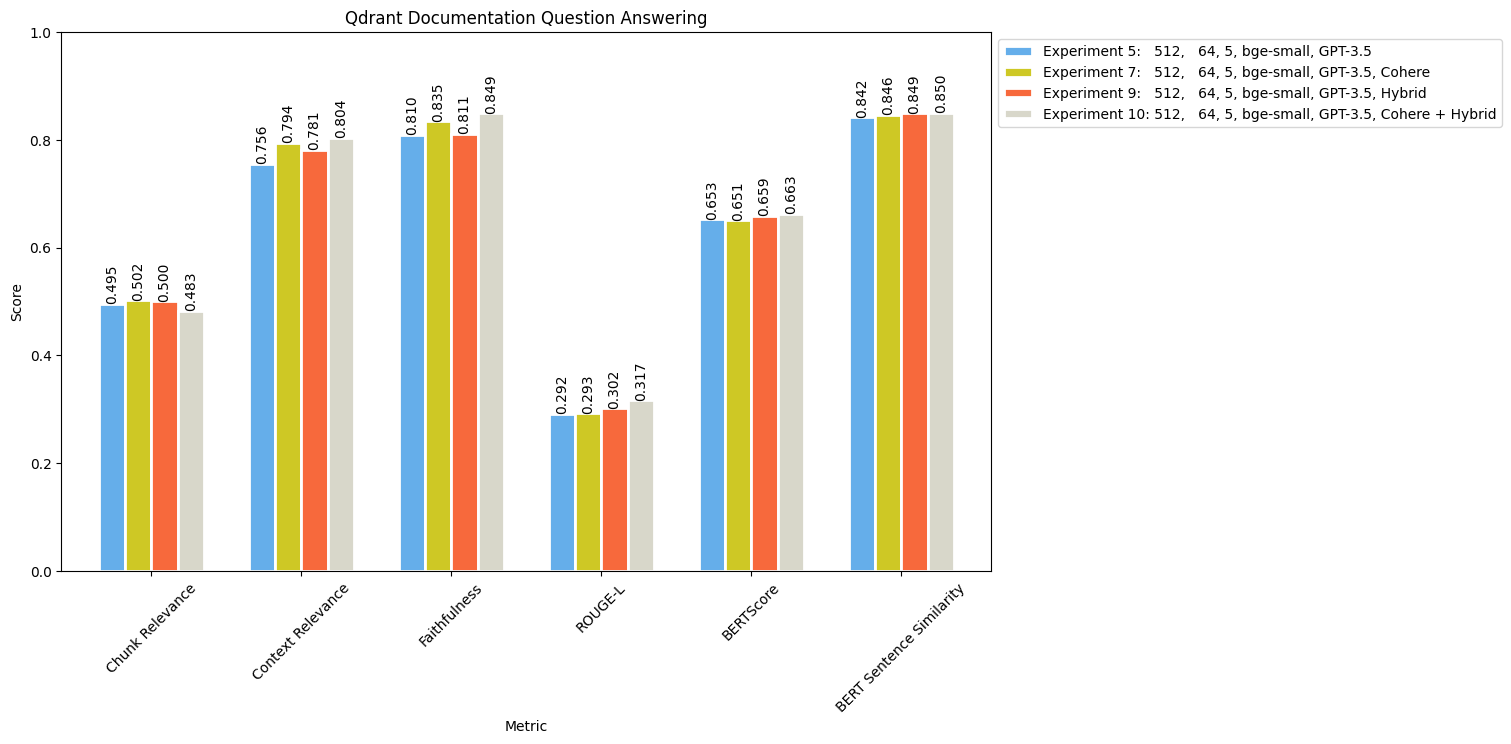

In [358]:
exp10 = ['Experiment 10: 512,   64, 5, bge-small, GPT-3.5, Cohere + Hybrid'] + experiment_10[main_metrics].describe().loc['mean'].to_list()

stats = pd.DataFrame([exp5, exp7, exp9, exp10], columns=['experiment']+main_metrics)
stats = pd.pivot_table(stats, columns='experiment')
stats = stats.loc[["Chunk Relevance","Context Relevance","Faithfulness","ROUGE-L","BERTScore","BERT Sentence Similarity"]]

stats = stats[[
       'Experiment 5:   512,   64, 5, bge-small, GPT-3.5',
       'Experiment 7:   512,   64, 5, bge-small, GPT-3.5, Cohere',
       'Experiment 9:   512,   64, 5, bge-small, GPT-3.5, Hybrid',
       'Experiment 10: 512,   64, 5, bge-small, GPT-3.5, Cohere + Hybrid',]]

ax1 = stats.plot(kind='bar',
                 figsize=(12,7),
                 width=0.7, edgecolor="w", linewidth=2,
                 ylim=[0,1],
                 xlabel='Metric',
                 ylabel="Score",
                 title="Qdrant Documentation Question Answering",
                 color=["#65AEEA","#CEC825","#F7693C","#D8D7CA","#7D7D6C"])

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.tick_params(axis='x', rotation=45)

for container in ax1.containers:
  ax1.bar_label(container, fmt='%.3f', rotation=90)

In [361]:
print("Minimum Faithfulness scores:\n")
print('Top Naive RAG Implementation: ',experiment_5.Faithfulness.min())
print('Top Reranked RAG Implementation: ',experiment_7.Faithfulness.min())
print('Hybrid Search Implementation: ',experiment_9.Faithfulness.min())
print('Hybrid + Reranked Implementation: ',experiment_10.Faithfulness.min())

with pd.option_context('display.max_colwidth', 0):
    display(experiment_10.loc[[67,54]][['content.input_text', 'content.answer','content.documents','Chunk Relevance','Context Relevance','Faithfulness']
                ].sort_values(by='Faithfulness').head(2))

Minimum Faithfulness scores:

Top Naive RAG Implementation:  0.0397113561630249
Top Reranked RAG Implementation:  0.09272611141204834
Hybrid Search Implementation:  0.3844997389242053
Hybrid + Reranked Implementation:  0.14902471303939824


,content.input_text,content.answer,content.documents,Chunk Relevance,Context Relevance,Faithfulness
67,What does Qdrant not plan to support in the future?,"In the future, Qdrant does not plan to support BM25 or other non-vector-based retrieval or ranking functions, built-in ontologies or knowledge graphs, and query analyzers and other NLP tools. Qdrant aims to introduce support for sparse vectors, as used in SPLADE or similar models, but does not intend to incorporate the aforementioned features into its functionality. Users can combine Qdrant with specialized tools, including full-text search engines, to complement its capabilities.","[What Qdrant plans to introduce in the future:\n\n\n\n- Support for sparse vectors, as used in [SPLADE](https://github.com/naver/splade) or similar models\n\n\n\nWhat Qdrant doesn't plan to support:\n\n\n\n- BM25 or other non-vector-based retrieval or ranking functions\n\n- Built-in ontologies or knowledge graphs\n\n- Query analyzers and other NLP tools\n\n\n\nOf course, you can always combine Qdrant with any specialized tool you need, including full-text search engines., . In the default build configuration, qdrant does not include support for all languages, due to the increasing size of the resulting binary. Chinese, Japanese and Korean languages are not enabled by default, but can be enabled by building qdrant from source with `--features multiling-chinese,multiling-japanese,multiling-korean` flags., Other than as expressly set out in these terms, Qdrant does not make any commitments about the Solution and Website’s availability or ability to meet your expectations.\n\n\n\n\n\n### 15. Liability\n\n\n\nIn no event shall Qdrant be liable for:\n\n\n\n\n\n* any indirect damages of any kind, including any potential loss of business;\n\n* any damage or loss which is not caused by a breach of its obligations under the T&Cs;\n\n* disruptions or damage inherent in an electronic communications network;, ## Known limitations\n\n\n\n1. Pinecone does not support arbitrary JSON metadata, but a flat structure with strings, numbers, booleans, or lists of strings used as values. Qdrant accepts any JSON object as a payload, even nested structures.\n\n2. NULL values are not supported in Pinecone metadata but are handled properly by Qdrant.\n\n3. The maximum size of Pinecone metadata is 40kb per vector. \n\n4. Pinecone, unlike Qdrant, does not support geolocation and filtering based on geographical criteria., You acknowledge that you are informed that the unavailability of the Solution may be the result of (a) a maintenance operation, (b) an urgent operation relating in particular to security, (c) a case of “force majeure” or (d) the malfunctioning of computer applications of Qdrant's third-party partners. Qdrant undertakes to restore the availability of the Solution as soon as possible once the problem causing the unavailability has been resolved.]",0.497534,0.797125,0.831596
54,What is the default scoring metric used in Qdrant for search operations?,"The default scoring metric used in Qdrant for search operations is `Dot product`. It is not necessary to specify this metric explicitly as it is the default setting. However, Qdrant also supports other distance metrics such as Cosine for scoring. When performing a search operation in Qdrant, if no specific metric is mentioned, the system will automatically use the Dot product as the scoring metric.","[| Index| Sparse Query | Dense Query |\n\n| --- | --- | --- | \n\n| Scoring Metric | Default is `Dot product`, no need to specify it | `Distance` has supported metrics e.g. Dot, Cosine |\n\n| Search Type | Always exact in Qdrant | HNSW is an approximate NN |\n\n| Return Behaviour | Returns only vectors with non-zero values in the same indices as the query vector | Returns `limit` vectors |\n\n\n\nIn general, the speed of the search is proportional to the number of non-zero values in the query vector.\n\n\n\n```http, qdrant: &QdrantClient,\n\n) -> Result<Vec<ScoredPoin

### **Conclusions**



The table below illustrates the advancements achieved through 10 experiments. 
It showcases the score improvements between our initial and final experiment, all attained without altering the prompt. 
These enhancements predominantly stem from adjustments in the RAG implementation.


| Iteration    | Chunk Relevance | Context Relevance | Faithfulness | ROUGE-L  | BERTScore | BERT Sentence Similarity |
|--------------|-----------------|-------------------|--------------|----------|-----------|--------------------------|
| Experiment 1 | 0.469500        | 0.721464          | 0.766502     | 0.232352 | 0.621800  | 0.817773                 |
| Experiment 10| 0.482720        | 0.804072          | 0.849271     | 0.316757 | 0.662770  | 0.850435                 |


The table below provides an **overview of the key experiments** conducted, along with their average performance. 
This includes the top-performing Naive RAG approach (Experiment 5), as well as four advanced RAG implementations, each testing different rerankers and a multivector hybrid search approach.

In [359]:
results = pd.DataFrame([exp5, exp6, exp7, exp8, exp9, exp10], columns=['experiment']+main_metrics)
results['iteration'] = results.experiment.str.split(':').str[0]
results[['chunk size', 'chunk overlap', 'num docs', 'embedding model','LLM', 'Advanced RAG']] = results.experiment.str.split(':').str[1].str.split(',', expand=True)

display(results[['iteration', "Advanced RAG",'chunk size', 'chunk overlap', 'num docs', 'embedding model','LLM']+main_metrics])

,iteration,Advanced RAG,chunk size,chunk overlap,num docs,embedding model,LLM,Context Relevance,Chunk Relevance,Faithfulness,ROUGE-L,BERT Sentence Similarity,BERTScore
0,Experiment 5,None,512,64,5,bge-small,GPT-3.5,0.755696,0.495340,0.809529,0.291575,0.841584,0.652713
1,Experiment 6,Mixedbread,512,64,5,bge-small,GPT-3.5,0.785544,0.490597,0.824394,0.288392,0.849143,0.649738
2,Experiment 7,Cohere,512,64,5,bge-small,GPT-3.5,0.793897,0.502324,0.834533,0.292739,0.846161,0.650726
3,Experiment 8,Jina-Colbert,512,64,5,bge-small,GPT-3.5,0.776272,0.480759,0.803262,0.287293,0.841771,0.650255
4,Experiment 9,Hybrid,512,64,5,bge-small,GPT-3.5,0.780795,0.500447,0.810670,0.301904,0.849098,0.658590
5,Experiment 10,Cohere + Hybrid,512,64,5,bge-small,GPT-3.5,0.804072,0.482720,0.849271,0.316757,0.850435,0.662770


You can see how starting from zero, you can build an improved RAG system by making **evaluation-informed changes** throughout your experimentation.

**If you're interested, you can request access to Quotient by joining the waitlist on [quotientai.co](https://www.quotientai.co/)**